# Sprint 2 — New predictor

*This demo includes the two new predictors we made for sprint 2. Both are based on the random forest model.*

1. The first predictor is a random forest based on classification. It predicts what the next event type will be.
2. The second predictor is a random forest based on regression. It predicts what the next event time will be.

Because we're using a smaller dataset, running this entire file usually takes around 20 seconds.

# 1. Setup

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Reading the data
data_2012 = pd.read_csv('data_2012_small.csv')
data_2012['nextEvent'] = data_2012['event']

# 2. Random Forest Classifier (Event Type Prediction)
### 2.1 Pre-processing and feature engineering

In [2]:
# Construct a list of all case IDs
list_case_id = data_2012['case'].unique()

# Add the type of the next event as a feature to the dataset for supervised training
for case_id in list_case_id:
    for r in data_2012[data_2012['case'] == case_id].T:
        if r + 1 in data_2012[data_2012['case'] == case_id].T:
            data_2012.loc[r, 'nextEvent'] = data_2012.loc[r + 1, 'event']
        else:
            # The last event in a trace doesn't have a next event, it's value is defined as NaN
            data_2012.loc[r, 'nextEvent'] = 'NaN'

In [3]:
# Make dummy variables from the event type for modelling purposes
event = pd.get_dummies(data_2012['event'])

# Put the dummy variables back in the dataframe as columns
df = pd.concat([data_2012, event], axis=1)
df.drop(['event'], axis=1, inplace=True)


In [4]:
# Drop the features the model doesn't use
X = df.drop(columns=['startTime', 'completeTime', 'REG_DATE', 'nextEvent', 'W_Valideren aanvraag', 'case', 'AMOUNT_REQ', 'org:resource'])
y = df['nextEvent']

# Scaling all features 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

### 2.2 Splitting the test and train data

In [5]:
# Split the test and train data, without shuffle. this is because the events in the same case should stay with each other
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=False)

### 2.3 Training the model and making the predictions

In [6]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

### 2.4 Prediction accuracy analysis

The prediction accuracy is shown in a confusion matrix below. The numbers on the axes represent the event types, hence the diagonal (top-left to bottom-right) represents the correct predictions.

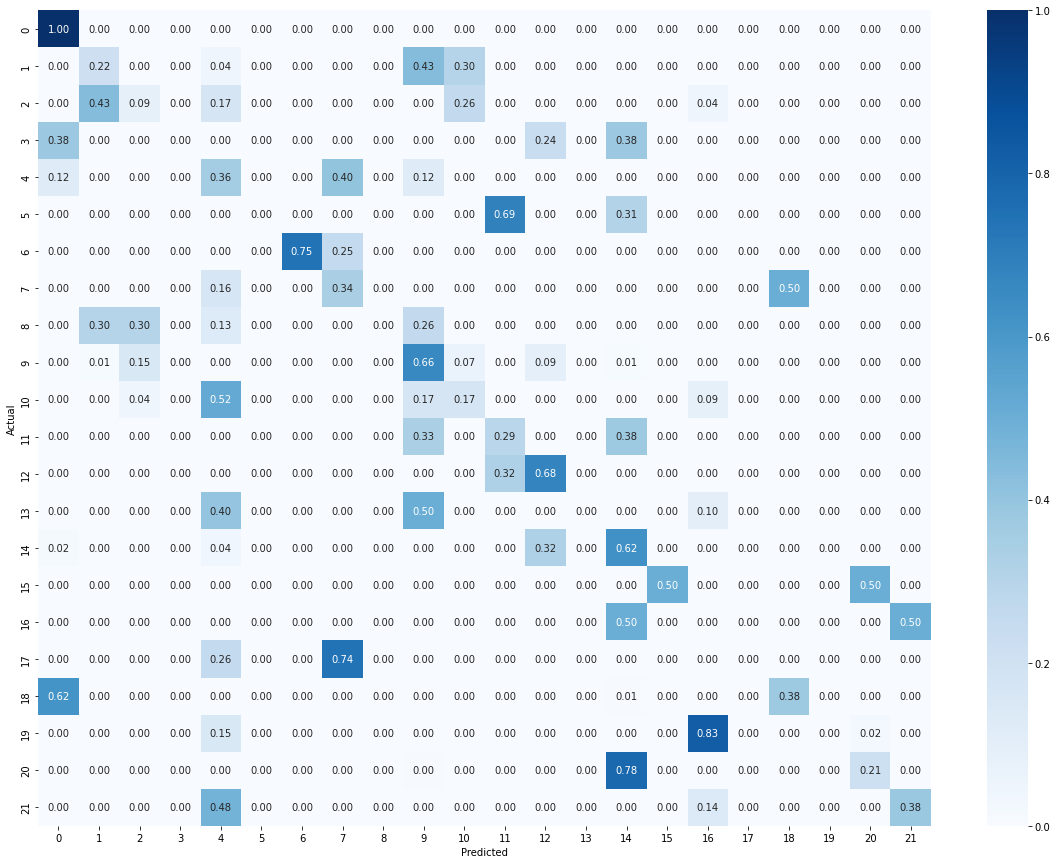

In [7]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
cm =confusion_matrix(y_test, rfc_pred)

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues', ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

The textual analysis below shows a lot of statistics about the prediction. The main value to note is the "accuracy" field, which was about 35% in our tests.

In [8]:
classification_report(y_test, rfc_pred, output_dict=True)

C:\Users\20203477\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20203477\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\20203477\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

{'A_ACCEPTED': {'precision': 0.2922077922077922,
  'recall': 1.0,
  'f1-score': 0.45226130653266333,
  'support': 45},
 'A_ACTIVATED': {'precision': 0.21739130434782608,
  'recall': 0.21739130434782608,
  'f1-score': 0.21739130434782608,
  'support': 23},
 'A_APPROVED': {'precision': 0.08695652173913043,
  'recall': 0.08695652173913043,
  'f1-score': 0.08695652173913043,
  'support': 23},
 'A_CANCELLED': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 21},
 'A_DECLINED': {'precision': 0.12,
  'recall': 0.35714285714285715,
  'f1-score': 0.17964071856287425,
  'support': 42},
 'A_FINALIZED': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 45},
 'A_PARTLYSUBMITTED': {'precision': 1.0,
  'recall': 0.7456140350877193,
  'f1-score': 0.8542713567839196,
  'support': 114},
 'A_PREACCEPTED': {'precision': 0.34210526315789475,
  'recall': 0.33620689655172414,
  'f1-score': 0.3391304347826087,
  'support': 116},
 'A_REGISTERED': {'precision': 0.0,
  'recal

# 3. Random Forest Regressor (Event Time Prediction)

### 3.1 Loading the data

In [9]:
# Reading the data
data_2012 = pd.read_csv('data_2012_small.csv')
data_2012['nextEvent'] = data_2012['event']
data_2012 = data_2012.rename(columns={'Unnamed: 0': 'event_index'})


### 3.2 Feature engineering

We're training the tree on two features:

1. The amount of time that elapsed from the start of the case until the start of this event (in seconds)
2. The current event (turned into dummies, much like the classification model above)

These features are not the ideal features to train a sequential time prediction model on, and thus the performance is rather bad. It produces a Root-Mean-Squared-Error from around 160.000, which comes down to about 44 hours.

Our next step is to see if we can engineer better features to make the model work, or else move on to a different model for time prediction.

In [10]:
# Add the next event time for supervised learning
def add_next_event_time(df):
  df['nextEventTime'] = pd.NaT
  df_grouped_sorted = df.sort_values('startTime').groupby('case')
  
  for name, case in df_grouped_sorted:
    for row_index, row in case.reset_index().iterrows():
      location_mask = df['event_index'] == row['event_index']
      if row_index < len(case) - 1:
        df.loc[location_mask, 'nextEventTime'] = case['startTime'].iloc[row_index + 1]
      else:
        df.loc[location_mask, 'nextEventTime'] = pd.NaT

  return df


# Add the start time of the current event as a relative value from the start of the case (in seconds) for numerical training
def add_start_time_rel(df):
  df['startTimeSec'] = pd.to_datetime(df['startTime']).values.astype(np.int64) // 10 ** 9
  df['regDateSec'] = pd.to_datetime(df['REG_DATE']).values.astype(np.int64) // 10 ** 9

  df['startTimeRel'] = df['startTimeSec'] - df['regDateSec']

  df = df.drop(['startTimeSec', 'regDateSec'], axis=1)
  return df


# Add the next event time as a relative value from the start of the case (in seconds) for numerical prediction
def add_next_event_time_rel(df):
  df['startTimeSec'] = pd.to_datetime(df['startTime']).values.astype(np.int64) // 10 ** 9
  df['nextEventTimeSec'] = pd.to_datetime(df['nextEventTime']).values.astype(np.int64) // 10 ** 9

  df['nextEventTimeRel'] = df['nextEventTimeSec'] - df['startTimeSec']
  df.loc[pd.isnull(df['nextEventTime']), 'nextEventTimeRel'] = np.NaN

  df = df.drop(['startTimeSec', 'nextEventTimeSec'], axis=1)
  return df


data_2012 = add_next_event_time(data_2012)
data_2012 = add_next_event_time_rel(data_2012)
data_2012 = add_start_time_rel(data_2012)

In [11]:
# Data cleanup
data_2012 = data_2012.dropna()

# Make dummy variables from the event type for modelling purposes
event_dummies = pd.get_dummies(data_2012['event'])

# Put the dummy variables back in the dataframe as columns
df_2012_dummies = pd.concat([data_2012, event_dummies], axis=1)
df_2012_dummies.drop(['event', 'W_Valideren aanvraag'], axis=1, inplace=True)

df_2012_dummies.dropna(inplace=True)

# Drop the features the model doesn't use
X = df_2012_dummies.drop(columns=['startTime', 'completeTime', 'REG_DATE', 'nextEvent', 'case', 'AMOUNT_REQ', 'org:resource', 'nextEventTime', 'nextEventTimeRel', 'event_index'])
Y = df_2012_dummies['nextEventTimeRel']


### 3.3 Splitting the test and train data

In [12]:
# Split the test and train data, without shuffle. this is because the events in the same case should stay with each other
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)


### 3.4 Training the model and making the predictions

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time

start_time = time.time()

rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, Y_train)

# Predicting the values of our test dataset
rfr_pred = rfr.predict(X_test)

rmse = np.sqrt(mean_squared_error(Y_test, rfr_pred))

# Retrieving the accuracy of the model
print(f'RMSE score: {rmse}')

# Ending time
end_time = time.time()
print(f'\r\nThe execution of Random Forest (Regression) took {round(end_time - start_time)} seconds')

RMSE score: 160875.2369215428

The execution of Random Forest (Regression) took 1 seconds


### 3.5 Prediction analysis

As mentioned above, the performance is not great due to a suboptimal selection of features. The Root-Mean-Squared-Error above was around 160.000 in our tests, which comes down to about 44 hours.